In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

from astropy.table import Table, vstack

In [30]:
r_band = pd.read_csv('./ztfstar_r.csv')
r_band.head(3)

,objectid,hmjd_corrected,mag_corrected,mag_err_corrected,ztf_period,ztf_t0
0,281211100059894,[2458302.84064 2458338.69335 2458348.70112 245...,[17.245947 17.087202 16.972092 17.033354 16.96...,[0.03291968 0.03156926 0.03074799 0.03116951 0...,2.025573,2.457001e+06


In [31]:
def string_to_list(string):
    # Remove square brackets and split by spaces to create a list of values
    values_list = string.strip("[]").split()
    # Convert string values to floats
    values_list = [float(value) for value in values_list]
    return values_list

# Apply the function to the DataFrame column
r_band['hmjd_corrected'] = r_band['hmjd_corrected'].apply(string_to_list)
r_band['mag_corrected'] = r_band['mag_corrected'].apply(string_to_list)
r_band['mag_err_corrected'] = r_band['mag_err_corrected'].apply(string_to_list)

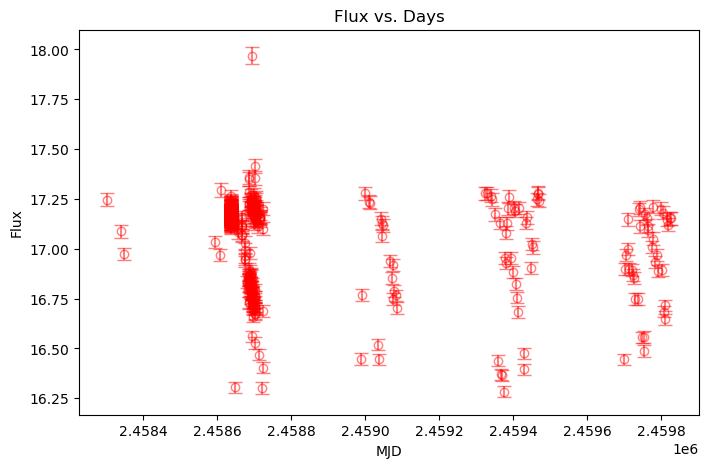

In [32]:
def data_reader(df):
    r_band_days = df['hmjd_corrected'].iloc[0]
    r_band_flux = df['mag_corrected'].iloc[0]
    r_band_err = df['mag_err_corrected'].iloc[0]
    
    return r_band_days, r_band_flux, r_band_err

days_r, fl_r, fl_err_r = data_reader(r_band)
# Plotting
fig = plt.figure(figsize=(8, 5))
plt.errorbar(days_r, fl_r, yerr=fl_err_r, fmt='o', capsize=5, mec='red', mfc='None', alpha=0.5, ecolor='red')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.title('Flux vs. Days')
plt.show()

#### Too Many Data Points! 

& Most of them are noisy (too close to each other)

Let's make a random selection with only 30 percent of the data

In [33]:
### what if we try a data selection? try random selection 20 percent of the data

selected_columns = ['hmjd_corrected', 'mag_corrected', 'mag_err_corrected']

# Define the percentage of data to select
percentage = 0.3

# Select 20% of the data from each selected column
selected_data_r = {col: random.sample(r_band[col].iloc[0], k=int(len(r_band[col].iloc[0]) * percentage)) for col in selected_columns}

# Create a new DataFrame with the selected data
r_band_selected = pd.DataFrame(selected_data_r)
print ('!!!! shape after selection !!!!', r_band_selected.shape)
r_band_selected.head()

!!!! shape after selection !!!! (117, 3)


,hmjd_corrected,mag_corrected,mag_err_corrected
0,2.459367e+06,17.112770,0.032413
1,2.458667e+06,16.844720,0.028329
2,2.458698e+06,16.445870,0.032535
3,2.458988e+06,17.195522,0.030624
4,2.458702e+06,17.193180,0.032094


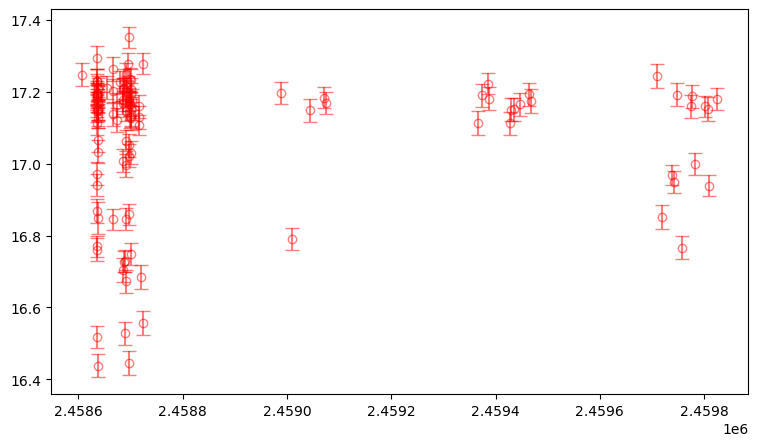

In [34]:
fig = plt.figure(figsize=(9, 5))

plt.errorbar(r_band_selected['hmjd_corrected'], r_band_selected['mag_corrected'], 
             yerr=r_band_selected['mag_err_corrected'], fmt='o', capsize=5, 
             mec='red', mfc='None', alpha=0.5, ecolor='red')

plt.show()

In [35]:
## after random selection sort the dataframe based on the time
r_band_selected_sorted = r_band_selected.sort_values(by='hmjd_corrected')
## adjust the days so that it starts at 0
r_band_selected_sorted['days_adjusted'] = r_band_selected_sorted['hmjd_corrected'] - r_band_selected_sorted['hmjd_corrected'].iloc[0]

r_band_selected_sorted.head(5)



,hmjd_corrected,mag_corrected,mag_err_corrected,days_adjusted
74,2.458608e+06,17.247265,0.031993,0.00000
51,2.458637e+06,17.194592,0.029260,28.85508
5,2.458637e+06,17.295200,0.031961,28.85779
11,2.458637e+06,17.230770,0.032191,28.86185
82,2.458637e+06,17.220232,0.030236,28.86320


(28, 4)


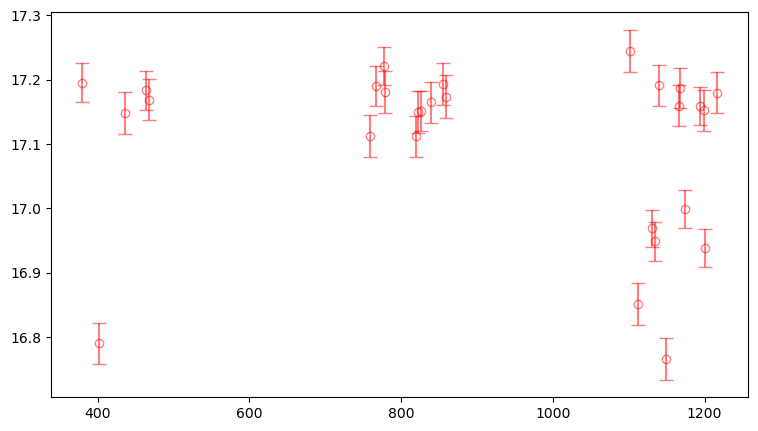

In [36]:
### select datapoints above >500

r_band_selected_sorted_hdays = r_band_selected_sorted.loc[r_band_selected_sorted['days_adjusted']>350]
print (r_band_selected_sorted_hdays.shape)

fig = plt.figure(figsize=(9, 5))
plt.errorbar(r_band_selected_sorted_hdays['days_adjusted'], r_band_selected_sorted_hdays['mag_corrected'], 
             yerr=r_band_selected_sorted_hdays['mag_err_corrected'], fmt='o', capsize=5, 
             mec='red', mfc='None', alpha=0.5, ecolor='red')

plt.show()

In [23]:
r_band_selected_sorted_hdays.head(5)

,hmjd_corrected,mag_corrected,mag_err_corrected,days_adjusted
111,2.458655e+06,16.748075,0.029962,306.15086
35,2.458666e+06,17.190730,0.033208,317.10220
76,2.458667e+06,17.183481,0.029868,318.13569
45,2.458675e+06,17.193302,0.029780,326.09819
57,2.458681e+06,16.369484,0.032544,332.05499


In [37]:
### reindex the frame and start from time counter 0; 
r_band_selected_sorted_hdays.reset_index(drop=True, inplace=True)
r_band_selected_sorted_hdays['days_adjusted_0'] = r_band_selected_sorted_hdays['days_adjusted'] - r_band_selected_sorted_hdays['days_adjusted'].iloc[0]
## center the mag at 0 ; i.e subtract mean from every mag
fl_mean_sorted_hdays = r_band_selected_sorted_hdays['mag_corrected'].mean()
r_band_selected_sorted_hdays['mag_mean_center'] = r_band_selected_sorted_hdays['mag_corrected'] - fl_mean_sorted_hdays
r_band_selected_sorted_hdays.head(5)

/tmp/ipykernel_9703/3517319444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_band_selected_sorted_hdays['days_adjusted_0'] = r_band_selected_sorted_hdays['days_adjusted'] - r_band_selected_sorted_hdays['days_adjusted'].iloc[0]
/tmp/ipykernel_9703/3517319444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_band_selected_sorted_hdays['mag_mean_center'] = r_band_selected_sorted_hdays['mag_corrected'] - fl_mean_sorted_hdays


,hmjd_corrected,mag_corrected,mag_err_corrected,days_adjusted,days_adjusted_0,mag_mean_center
0,2.458988e+06,17.195522,0.030624,380.00661,0.00000,0.092458
1,2.459010e+06,16.790440,0.031891,401.87587,21.86926,-0.312624
2,2.459044e+06,17.148163,0.032213,435.78751,55.78090,0.045099
3,2.459072e+06,17.183481,0.029704,463.70735,83.70074,0.080417
4,2.459076e+06,17.168922,0.031669,467.72748,87.72087,0.065858


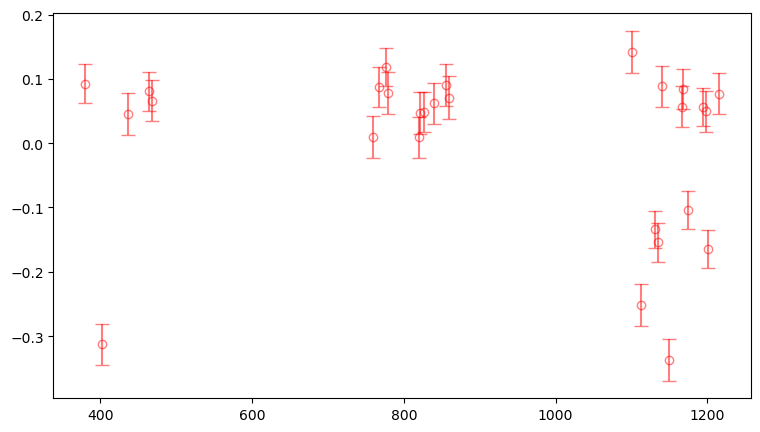

In [38]:
fig = plt.figure(figsize=(9, 5))
plt.errorbar(r_band_selected_sorted_hdays['days_adjusted'], r_band_selected_sorted_hdays['mag_mean_center'], 
             yerr=r_band_selected_sorted_hdays['mag_err_corrected'], fmt='o', capsize=5, 
             mec='red', mfc='None', alpha=0.5, ecolor='red')

plt.show()

In [39]:
### assign wavelength info to dataframe: for red it is 6231. 

r_band_selected_sorted_hdays['r_wl'] = 6231.0

### create the x array from day and wavelegnth

days_ad_r_sort_h = r_band_selected_sorted_hdays['days_adjusted_0'].to_numpy()
wl_r_ad_h = r_band_selected_sorted_hdays['r_wl'].to_numpy()

x_data = np.vstack([days_ad_r_sort_h, wl_r_ad_h]).T

print (x_data.shape)


### calculate SNR and scale factor

fl_r_h_arr = r_band_selected_sorted_hdays['mag_mean_center'].to_numpy()
fl_err_r_h_arr = r_band_selected_sorted_hdays['mag_err_corrected'].to_numpy()

signal_to_noise = np.abs(fl_r_h_arr) / np.sqrt(fl_err_r_h_arr ** 2 + (1e-2 * np.max(fl_r_h_arr)) ** 2)

scale_r = np.abs(fl_r_h_arr[np.argmax(signal_to_noise)])
print ('check the scale factor: ',  scale_r)

(28, 2)
check the scale factor:  0.33726721428571693


/tmp/ipykernel_9703/277913182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_band_selected_sorted_hdays['r_wl'] = 6231.0


In [40]:
### create the fit function (kernel) and fit to data

kernels = (2 * scale_r) ** 2 * Matern(length_scale=1, length_scale_bounds=(0, 30), nu=1.5)


gp = GaussianProcessRegressor(kernel=kernels)
gp.fit(x_data, fl_r_h_arr) # fit to time & flux 


/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


GaussianProcessRegressor(kernel=0.675**2 * Matern(length_scale=1, nu=1.5))

In [41]:
gp_times = np.linspace(min(days_ad_r_sort_h), max(days_ad_r_sort_h), 100)
print (gp_times.shape, len(gp_times)) # let's say we want to have 100 data points instead of 25

gp_wavelengths_r = np.ones(len(gp_times)) * 6231.

pred_x_data = np.vstack([gp_times, gp_wavelengths_r]).T
y_mean_fl_r, y_std_fl_r = gp.predict(pred_x_data, return_std=True) # get the predicted values

obj_gp_pb_array = np.column_stack((gp_times, y_mean_fl_r, y_std_fl_r))

obj_gps = []

obj_gp_pb = Table([obj_gp_pb_array[:, 0], 
                       obj_gp_pb_array[:, 1], 
                       obj_gp_pb_array[:, 2], 
                       [6231.] * len(gp_times),], names=["mjd", "flux", "flux_err", "filter"],)


if len(obj_gps)==0:
        obj_gps = obj_gp_pb
else:
    obj_gps = vstack((obj_gps, obj_gp_pb))
        
obj_gps = obj_gps.to_pandas()
        
    
obj_gps.head(3)

(100,) 100


,mjd,flux,flux_err,filter
0,0.000000,0.092458,0.000010,6231.0
1,8.441039,0.003176,0.134439,6231.0
2,16.882078,-0.071381,0.131041,6231.0


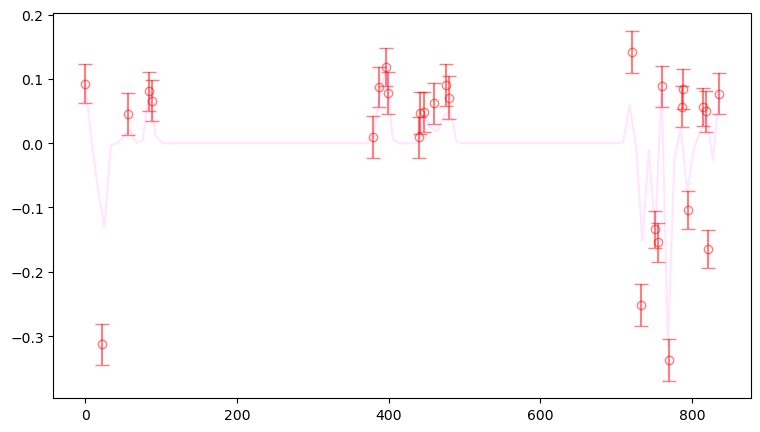

In [42]:
fig = plt.figure(figsize=(9, 5))

plt.errorbar(days_ad_r_sort_h, fl_r_h_arr, yerr=fl_err_r_h_arr, fmt='o', capsize=5, 
             mec='red', mfc='None', alpha=0.5, ecolor='red')

plt.plot(obj_gps['mjd'], obj_gps['flux'],   
                 color='magenta', alpha=0.1,)

plt.show()

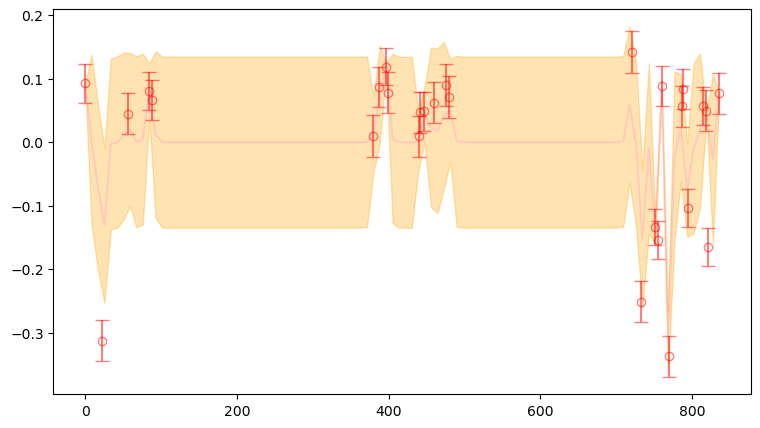

In [43]:
fig = plt.figure(figsize=(9, 5))

plt.errorbar(days_ad_r_sort_h, fl_r_h_arr, yerr=fl_err_r_h_arr, fmt='o', capsize=5, 
             mec='red', mfc='None', alpha=0.5, ecolor='red')

plt.plot(obj_gps['mjd'], obj_gps['flux'],   
                 color='magenta', alpha=0.1,)

plt.fill_between(x=obj_gps['mjd'], 
                 y1=obj_gps['flux']-obj_gps['flux_err'], 
                 y2=obj_gps['flux']+obj_gps['flux_err'], 
                 color='orange', alpha=0.3, label=None)

plt.show()